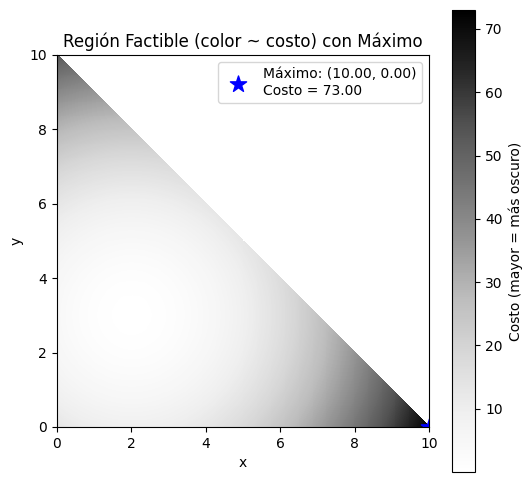

f(4, 5) = 8


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Definir la función de costo
def costo(x, y):
    return (x - 2)**2 + (y - 3)**2

# Función para graficar la región factible con colores basados en el costo y marcar el máximo
def plot_region_max(c=10, x_min=0, y_min=0):
    # Crear un grid de puntos
    x = np.linspace(x_min, c, 400)
    y = np.linspace(y_min, c, 400)
    X, Y = np.meshgrid(x, y)
    
    # Evaluar la función de costo en cada punto del grid
    Z = costo(X, Y)
    
    # Definir la región factible: x>=x_min, y>=y_min y x+y<=c
    factible = (X >= x_min) & (Y >= y_min) & (X + Y <= c)
    
    # Para los puntos no factibles, asignamos NaN para que no se coloreen
    Z_feasible = np.where(factible, Z, np.nan)
    
    # Calcular el máximo en la región factible
    max_idx = np.nanargmax(Z_feasible)
    X_flat = X.flatten()
    Y_flat = Y.flatten()
    Z_flat = Z_feasible.flatten()
    x_max_val = X_flat[max_idx]
    y_max_val = Y_flat[max_idx]
    max_val = Z_flat[max_idx]
    
    # Graficar la región factible coloreada por el costo
    plt.figure(figsize=(6,6))
    im = plt.imshow(Z_feasible, extent=(x_min, c, y_min, c),
                    origin='lower', cmap='Greys', interpolation='nearest')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Región Factible (color ~ costo) con Máximo')
    
    # Agregar la barra de color
    cbar = plt.colorbar(im)
    cbar.set_label('Costo (mayor = más oscuro)')
    
    # Marcar el máximo en la gráfica
    plt.scatter(x_max_val, y_max_val, color='blue', marker='*', s=150,
                label=f'Máximo: ({x_max_val:.2f}, {y_max_val:.2f})\nCosto = {max_val:.2f}')
    plt.legend()
    plt.show()

# Función para evaluar la función de costo en un punto dado
def evaluar_punto(x, y):
    valor = costo(x, y)
    print(f"f({x}, {y}) = {valor}")

# Ejemplo de uso:
plot_region_max(c=10)
evaluar_punto(4, 5)


In [3]:
class SparseCOO:
    def __init__(self, shape):
        self.shape = shape
        self.rows = []
        self.cols = []
        self.data = []
        
    def add_element(self, i, j, value):
        if value != 0:
            self.rows.append(i)
            self.cols.append(j)
            self.data.append(value)
            
    def to_dense(self):
        dense = np.zeros(self.shape)
        for r, c, v in zip(self.rows, self.cols, self.data):
            dense[r, c] = v
        return dense
    
    def __add__(self, other):
        # Suma de dos matrices sparse: se suma elemento a elemento.
        result = SparseCOO(self.shape)
        # Agregar elementos de la primera matriz
        for i, j, v in zip(self.rows, self.cols, self.data):
            result.add_element(i, j, v)
        # Agregar elementos de la segunda matriz
        for i, j, v in zip(other.rows, other.cols, other.data):
            # Buscar si el elemento ya existe en result
            indices = list(zip(result.rows, result.cols))
            if (i, j) in indices:
                idx = indices.index((i, j))
                result.data[idx] += v
            else:
                result.add_element(i, j, v)
        return result


In [4]:
import scipy.sparse as sp
import time

# Crear una matriz densa aleatoria y hacerla sparse
np.random.seed(0)
dense = np.random.rand(200, 200)
dense[dense < 0.95] = 0  # Hacemos que la matriz sea mayormente cero

# Implementación propia: SparseCOO
t0 = time.time()
sparse_custom = SparseCOO(dense.shape)
for i in range(dense.shape[0]):
    for j in range(dense.shape[1]):
        if dense[i, j] != 0:
            sparse_custom.add_element(i, j, dense[i, j])
t1 = time.time()

# Usando SciPy (COO)
t2 = time.time()
sparse_scipy = sp.coo_matrix(dense)
t3 = time.time()

print("Tiempo de creación - Implementación propia:", t1 - t0)
print("Tiempo de creación - SciPy COO:", t3 - t2)

# Operación: suma de dos matrices sparse
# Crear otra matriz densa y convertirla a sparse
dense2 = np.random.rand(200, 200)
dense2[dense2 < 0.95] = 0

# Con implementación propia
sparse_custom2 = SparseCOO(dense2.shape)
for i in range(dense2.shape[0]):
    for j in range(dense2.shape[1]):
        if dense2[i, j] != 0:
            sparse_custom2.add_element(i, j, dense2[i, j])
t4 = time.time()
sparse_sum_custom = sparse_custom + sparse_custom2
t5 = time.time()

# Con SciPy
sparse_scipy2 = sp.coo_matrix(dense2)
t6 = time.time()
sparse_sum_scipy = sparse_scipy + sparse_scipy2
t7 = time.time()

print("Tiempo de suma - Implementación propia:", t5 - t4)
print("Tiempo de suma - SciPy COO:", t7 - t6)


Tiempo de creación - Implementación propia: 0.010408401489257812
Tiempo de creación - SciPy COO: 0.0
Tiempo de suma - Implementación propia: 0.5427513122558594
Tiempo de suma - SciPy COO: 0.0


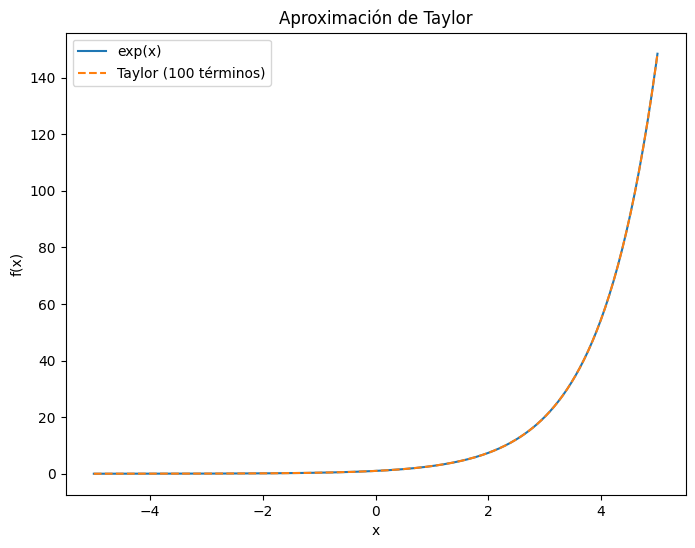

In [5]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

def taylor_series(func, a, n):
    x = sp.symbols('x')
    serie = 0
    for i in range(n):
        derivada = sp.diff(func, x, i)
        termino = derivada.subs(x, a) / sp.factorial(i) * (x - a)**i
        serie += termino
    # Convertir la serie en una función numérica
    return sp.lambdify(x, serie, 'numpy')

# Definir funciones disponibles
x = sp.symbols('x')
funciones = {
    'exp': sp.exp(x),
    'sin': sp.sin(x),
    'cos': sp.cos(x),
    'ln': sp.log(1+x),   # dominio: x > -1
    'atan': sp.atan(x)
}

# Ejemplo de uso:
# Usuario elige función, punto de expansión y número de términos
nombre_func = input("ingresa exp, sin, cos, ln, atan") # por ejemplo, 'sin'
a = int(input("ingrese centro"))                 # punto de expansión
n = int(input("ingrese la cantidad de terminos"))                 # número de términos

# Función original y su aproximación
f_original = sp.lambdify(x, funciones[nombre_func], 'numpy')
f_taylor = taylor_series(funciones[nombre_func], a, n)

# Graficar en un intervalo
x_vals = np.linspace(-5, 5, 400)
plt.figure(figsize=(8,6))
plt.plot(x_vals, f_original(x_vals), label=f'{nombre_func}(x)')
plt.plot(x_vals, f_taylor(x_vals), label=f'Taylor ({n} términos)', linestyle='--')
plt.xlabel('x')
plt.ylabel('f(x)')

plt.title('Aproximación de Taylor')
plt.legend()
plt.show()


In [ ]:
def gradiente_descendente(f, grad_f, x0, lr=0.1, tol=1e-6, max_iter=1000):
    x = np.array(x0, dtype=float)
    iter_count = 0
    while iter_count < max_iter:
        grad = np.array(grad_f(x))
        if np.linalg.norm(grad) < tol:
            break
        x = x - lr * grad
        iter_count += 1
    return x, iter_count

# Función y gradiente
def f_opt(x):
    return (x[0]-2)**2 + (x[1]-3)**2

def grad_f_opt(x):
    return [2*(x[0]-2), 2*(x[1]-3)]

# Ejecución con punto inicial y tasa de aprendizaje modificable
x0 = [0, 0]
sol, iteraciones = gradiente_descendente(f_opt, grad_f_opt, x0, lr=0.1)
print("Gradiente Descendente -> Solución:", sol, "Iteraciones:", iteraciones)


Gradiente Descendente -> Solución: [1.99999974 2.99999961] Iteraciones: 71


In [7]:
def newton_method(f, grad_f, hess_f, x0, tol=1e-6, max_iter=100):
    x = np.array(x0, dtype=float)
    iter_count = 0
    while iter_count < max_iter:
        grad = np.array(grad_f(x))
        if np.linalg.norm(grad) < tol:
            break
        H = np.array(hess_f(x))
        # Resolver H * delta = grad
        delta = np.linalg.solve(H, grad)
        x = x - delta
        iter_count += 1
    return x, iter_count

def hess_f_opt(x):
    return [[2, 0],
            [0, 2]]

sol_newton, iter_newton = newton_method(f_opt, grad_f_opt, hess_f_opt, x0)
print("Método de Newton -> Solución:", sol_newton, "Iteraciones:", iter_newton)


Método de Newton -> Solución: [2. 3.] Iteraciones: 1


In [8]:
from scipy.optimize import minimize

res = minimize(f_opt, x0, method='BFGS', options={'disp': True})
print("BFGS -> Solución:", res.x, "Iteraciones:", res.nit)


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 4
BFGS -> Solución: [1.99999999 2.99999999] Iteraciones: 3


Gradiente Descendente -> Solución: [1.99999966 2.99999975] Iteraciones: 74
Newton -> Solución: [2. 3.] Iteraciones: 2
BFGS -> Solución: [2.00000008 2.99999988] Iteraciones: 3
cambios en x y y 1.9999996630006667 2.9999997472504996
cambios en x y y 2.0 3.0
cambios en x y y 2.000000084913789 2.9999998788714057
iteraciones en gradiente descendente [array([-2.,  0.]), array([-1.2,  0.6]), array([-0.56,  1.08]), array([-0.048,  1.464]), array([0.3616, 1.7712]), array([0.68928, 2.01696]), array([0.951424, 2.213568]), array([1.1611392, 2.3708544]), array([1.32891136, 2.49668352]), array([1.46312909, 2.59734682]), array([1.57050327, 2.67787745]), array([1.65640262, 2.74230196]), array([1.72512209, 2.79384157]), array([1.78009767, 2.83507326]), array([1.82407814, 2.8680586 ]), array([1.85926251, 2.89444688]), array([1.88741001, 2.91555751]), array([1.90992801, 2.93244601]), array([1.92794241, 2.9459568 ]), array([1.94235392, 2.95676544]), array([1.95388314, 2.96541235]), array([1.96310651, 2.972

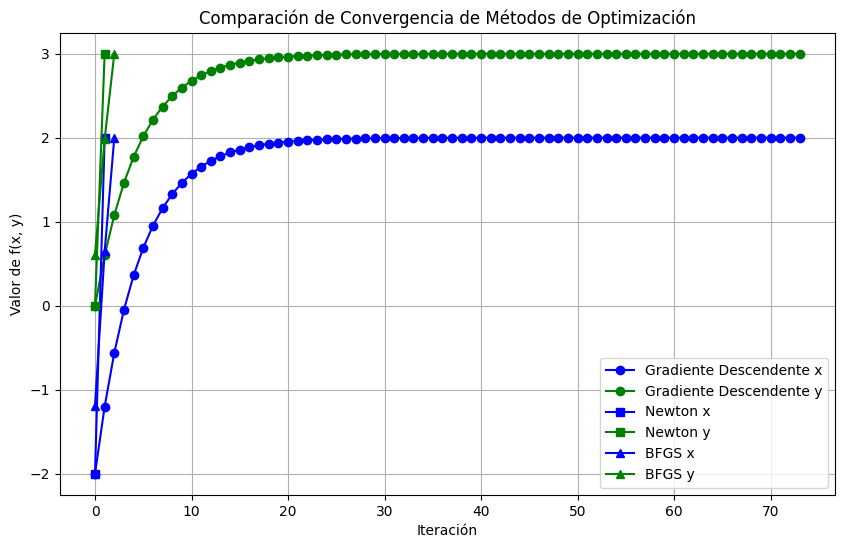

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# =============================================================================
# Definición de la función objetivo, su gradiente y su Hessiana
# =============================================================================

def f_opt(x):
    """
    Función objetivo: f(x,y) = (x-2)^2 + (y-3)^2
    Parámetros:
      - x: array con dos componentes [x, y]
    Retorna:
      - Valor de la función evaluada en x
    """
    return (x[0] - 2)**2 + (x[1] - 3)**2

def grad_f_opt(x):
    """
    Gradiente de la función f_opt.
    Calcula ∇f(x,y) = [2*(x-2), 2*(y-3)]
    Parámetros:
      - x: array [x, y]
    Retorna:
      - Array con las derivadas parciales respecto a x e y
    """
    return np.array([2*(x[0] - 2), 2*(x[1] - 3)])

def hess_f_opt(x):
    """
    Hessiana de la función f_opt.
    Para f(x,y) = (x-2)^2+(y-3)^2, la Hessiana es constante:
      H = [[2, 0],
           [0, 2]]
    Parámetros:
      - x: array [x, y] (no se utiliza en este caso, ya que es constante)
    Retorna:
      - Matriz Hessiana 2x2
    """
    return np.array([[2, 0],
                     [0, 2]])

# =============================================================================
# Método 1: Gradiente Descendente
# =============================================================================

def gradiente_descendente(f, grad_f, x0, lr=0.1, tol=1e-6, max_iter=1000):
    """
    Optimización mediante Gradiente Descendente.
    
    Parámetros:
      - f: función objetivo
      - grad_f: función que calcula el gradiente de f
      - x0: punto inicial (array)
      - lr: tasa de aprendizaje
      - tol: tolerancia para la norma del gradiente
      - max_iter: número máximo de iteraciones
      
    Retorna:
      - x: solución final
      - iterates: lista de puntos (soluciones) en cada iteración
      - f_values: lista de valores de f en cada iteración
    """
    x = np.array(x0, dtype=float)   # Inicializar la solución
    iterates = [x.copy()]           # Almacenar el punto inicial
    f_values = [f(x)]               # Almacenar el valor inicial de la función
    
    for i in range(max_iter):
        grad = grad_f(x)            # Calcular el gradiente en el punto x
        # Si la norma del gradiente es menor que la tolerancia, detener el algoritmo
        if np.linalg.norm(grad) < tol:
            break
        x = x - lr * grad           # Actualizar x usando la regla del gradiente descendente
        iterates.append(x.copy())   # Guardar el nuevo punto
        f_values.append(f(x))       # Guardar el nuevo valor de la función
        
    return x, iterates, f_values

# =============================================================================
# Método 2: Método de Newton
# =============================================================================

def newton_method(f, grad_f, hess_f, x0, tol=1e-6, max_iter=100):
    """
    Optimización mediante el Método de Newton.
    
    Parámetros:
      - f: función objetivo
      - grad_f: función que calcula el gradiente de f
      - hess_f: función que calcula la Hessiana de f
      - x0: punto inicial (array)
      - tol: tolerancia para la norma del gradiente
      - max_iter: número máximo de iteraciones
      
    Retorna:
      - x: solución final
      - iterates: lista de puntos en cada iteración
      - f_values: lista de valores de f en cada iteración
    """
    x = np.array(x0, dtype=float)
    iterates = [x.copy()]           # Almacenar el punto inicial
    f_values = [f(x)]               # Almacenar el valor inicial de f
    
    for i in range(max_iter):
        grad = grad_f(x)            # Calcular el gradiente
        # Si la norma del gradiente es menor que la tolerancia, se alcanza la convergencia
        if np.linalg.norm(grad) < tol:
            break
        H = hess_f(x)               # Calcular la Hessiana
        delta = np.linalg.solve(H, grad)  # Resolver el sistema H * delta = gradiente
        x = x - delta               # Actualizar x
        iterates.append(x.copy())   # Guardar el nuevo punto
        f_values.append(f(x))       # Guardar el nuevo valor de f
        
    return x, iterates, f_values

# =============================================================================
# Método 3: BFGS utilizando SciPy
# =============================================================================

def bfgs_method(f, x0, tol=1e-6, max_iter=1000):
    """
    Optimización mediante el método BFGS (cuasi-Newton) usando la función minimize de SciPy.
    
    Parámetros:
      - f: función objetivo
      - x0: punto inicial (array)
      - tol: tolerancia para la convergencia
      - max_iter: número máximo de iteraciones
      
    Retorna:
      - res: objeto resultado de SciPy (contiene la solución y otros datos)
      - iterates: lista de puntos generados en cada iteración (usando callback)
      - f_values: lista de valores de f en cada iteración
    """
    iterates = []   # Lista para almacenar los puntos en cada iteración
    f_values = []    # Lista para almacenar los valores de f correspondientes
    
    def callback(xk):
        """
        Función callback que se llama en cada iteración de BFGS.
        Almacena el punto actual y el valor de f en ese punto.
        """
        iterates.append(np.copy(xk))
        f_values.append(f(xk))
    
    # Ejecutar la optimización con método BFGS
    res = minimize(f, x0, method='BFGS', tol=tol,
                   options={'maxiter': max_iter, 'disp': False},
                   callback=callback)
    
    # Si el callback no se llamó (por ejemplo, convergió en 0 iteraciones), se agrega el punto inicial.
    if len(iterates) == 0:
        iterates.append(np.array(x0))
        f_values.append(f(x0))
    
    return res, iterates, f_values

# =============================================================================
# Ejecución de los tres métodos y comparación de sus resultados
# =============================================================================

# Definir el punto inicial común para todos los métodos
x0 = np.array([-2.0, 0.0])

# Método del Gradiente Descendente
x_grad, iter_grad, f_grad = gradiente_descendente(f_opt, grad_f_opt, x0, lr=0.1)

# Método de Newton
x_newton, iter_newton, f_newton = newton_method(f_opt, grad_f_opt, hess_f_opt, x0)

# Método BFGS (usando SciPy)
res_bfgs, iter_bfgs, f_bfgs = bfgs_method(f_opt, x0)

# Imprimir las soluciones y número de iteraciones para cada método
print("Gradiente Descendente -> Solución:", x_grad, "Iteraciones:", len(iter_grad))
print("Newton -> Solución:", x_newton, "Iteraciones:", len(iter_newton))
print("BFGS -> Solución:", res_bfgs.x, "Iteraciones:", len(iter_bfgs))

print("cambios en x y y", x_grad[0], x_grad[1])
print("cambios en x y y", x_newton[0], x_newton[1])
print("cambios en x y y", res_bfgs.x[0], res_bfgs.x[1])

print("iteraciones en gradiente descendente", iter_grad)

def separar_lista(lista):
    x = []
    y = []
    for i in lista:
        x.append(i[0])
        y.append(i[1])
    return x, y
  


# =============================================================================
# Gráfica de comparación de la convergencia de los tres métodos
# =============================================================================
x_grad, y_grad = separar_lista(iter_grad)
x_newton, y_newton = separar_lista(iter_newton)
x_bfgs, y_bfgs = separar_lista(iter_bfgs)


plt.figure(figsize=(10,6))
# Graficar la evolución del valor de f en cada iteración para Gradiente Descendente
plt.plot(x_grad, label='Gradiente Descendente x', marker='o', color='blue')
plt.plot(y_grad, label='Gradiente Descendente y', marker='o', color='green')
# Graficar la evolución del valor de f en cada iteración para el Método de Newton
plt.plot(x_newton, label='Newton x', marker='s', color='blue')
plt.plot(y_newton, label='Newton y', marker='s',color='green')
# Graficar la evolución del valor de f en cada iteración para BFGS
plt.plot(x_bfgs, label='BFGS x', marker='^', color='blue')
plt.plot(y_bfgs, label='BFGS y', marker='^',color='green')
plt.xlabel('Iteración')
plt.ylabel('Valor de f(x, y)')
plt.title('Comparación de Convergencia de Métodos de Optimización')
plt.legend()
plt.grid(True)
plt.show()
